In [1]:
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

This workflow has been influenced by the work done by the Theis lab: https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html

I recommend checking them out for additional info and alternative approaches

## Download and Prepare Data

GEO link:
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE235063

In [3]:
!mkdir data

In [4]:
!mv /home/mark/Downloads/GSE235063_RAW.tar data/

In [5]:
!tar -xf data/GSE235063_RAW.tar

In [8]:
!mv GSM* data/

In [15]:
!zcat data/GSM7494269_AML3_DX_raw_features.tsv.gz | head

ENSG00000243485	MIR1302-2HG
ENSG00000237613	FAM138A
ENSG00000186092	OR4F5
ENSG00000238009	AL627309.1
ENSG00000239945	AL627309.3
ENSG00000239906	AL627309.2
ENSG00000241599	AL627309.4
ENSG00000236601	AL732372.1
ENSG00000284733	OR4F29
ENSG00000235146	AC114498.1

gzip: stdout: Broken pipe


Note: the next few data preparation steps are optional and specific for this dataset

if you have .h5 or h5ad files already, you can skip the few parts

In [1]:
#rename files to have features instead of gene
#from data dir:
# $rename 's/genes/features/' *

add another column in the feature files to match expected output format:

In [16]:
files = os.listdir('data/')

In [18]:
ffs = [x for x in files if 'feature' in x]

In [20]:
!mkdir temp

In [21]:
for ff in ffs:
    with gzip.open('data/' + ff, 'rt') as f_in:
        with gzip.open('temp/' + ff , 'wt') as f_out:
            for line in f_in:
                f_out.write(line.strip() + "\tGene Expression\n")
                

In [22]:
!zcat temp/GSM7494269_AML3_DX_raw_features.tsv.gz | head

ENSG00000243485	MIR1302-2HG	Gene Expression
ENSG00000237613	FAM138A	Gene Expression
ENSG00000186092	OR4F5	Gene Expression
ENSG00000238009	AL627309.1	Gene Expression
ENSG00000239945	AL627309.3	Gene Expression
ENSG00000239906	AL627309.2	Gene Expression
ENSG00000241599	AL627309.4	Gene Expression
ENSG00000236601	AL732372.1	Gene Expression
ENSG00000284733	OR4F29	Gene Expression
ENSG00000235146	AC114498.1	Gene Expression

gzip: stdout: Broken pipe


In [23]:
!mv temp/* data/

In [24]:
sc.read_10x_mtx('data/', prefix = 'GSM7494269_AML3_DX_raw_')

AnnData object with n_obs × n_vars = 6794880 × 33538
    var: 'gene_ids', 'feature_types'

In [25]:
!mkdir raw_adata

In [34]:
#saving the files as h5ad for cellranger
for prefix in set([x.split('_raw')[0] + '_raw_' for x in files if 'processed' not in x and 'tar' not in x]):
    adata = sc.read_10x_mtx('data/', prefix = prefix)
    adata.write_h5ad('raw_adata/' + prefix + '.h5ad')

## Ambient RNA removal with cellbender

Alternative using SoupX: https://github.com/mousepixels/sanbomics_scripts/blob/main/soupX/soupX_python_test.ipynb

In [ ]:
# for file in *h5ad; do cellbender remove-background 
# --input $file
# --output ../clean_adata/$(basename $file .h5ad)denoised
# --total-droplets-included 50000 
# --cuda; done

In [5]:
#os.listdir('clean_adata/')

In [37]:
metrics = []
for file in [x for x in os.listdir('clean_adata/') if x.endswith('metrics.csv')]:
    _ = pd.read_csv('clean_adata/' + file,
                header = None, names = ['Metric', 'Value']).set_index('Metric').T

    _['File'] = file
    metrics.append(_)
    
metrics = pd.concat(metrics).reset_index()

In [38]:
metrics

Metric,index,total_raw_counts,total_output_counts,total_counts_removed,fraction_counts_removed,total_raw_counts_in_cells,total_counts_removed_from_cells,fraction_counts_removed_from_cells,average_counts_removed_per_cell,target_fpr,expected_cells,found_cells,output_average_counts_per_cell,ratio_of_found_cells_to_expected_cells,found_empties,fraction_of_analyzed_droplets_that_are_nonempty,convergence_indicator,overall_change_in_train_elbo,File
0,Value,32401298.0,31916568.0,484730.0,0.015,32401292.0,484724.0,0.015,60.613,0.01,8000.0,7997.0,3991.068,1.000,42003.0,0.160,0.210,818.798,GSM7494294_AML10_REM_raw_denoised_metrics.csv
1,Value,66959644.0,66108581.0,851063.0,0.013,66959660.0,851079.0,0.013,95.885,0.01,8000.0,8876.0,7448.015,1.109,41124.0,0.178,1.416,957.200,GSM7494320_AML26_REL_raw_denoised_metrics.csv
2,Value,98889072.0,97229381.0,1659691.0,0.017,98889080.0,1659699.0,0.017,161.985,0.01,8000.0,10246.0,9489.496,1.281,39754.0,0.205,0.773,2537.736,GSM7494326_AML12_DX_raw_denoised_metrics.csv
3,Value,6404987.0,6171930.0,233057.0,0.036,6404987.0,233057.0,0.036,24.717,0.01,8000.0,9429.0,654.569,1.179,40571.0,0.189,0.607,122.314,GSM7494313_AML28_REM_raw_denoised_metrics.csv
4,Value,40590968.0,39961889.0,629079.0,0.015,40590940.0,629051.0,0.015,58.773,0.01,8000.0,10703.0,3733.709,1.338,39297.0,0.214,0.966,1538.943,GSM7494296_AML11_REL_raw_denoised_metrics.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,Value,42653264.0,39980282.0,2672982.0,0.063,42653280.0,2672998.0,0.063,73.317,0.01,8000.0,36458.0,1096.612,4.557,13542.0,0.729,2.415,684.872,GSM7494331_AML13_REM_raw_denoised_metrics.csv
71,Value,40126384.0,39342411.0,783973.0,0.020,40126392.0,783981.0,0.020,67.104,0.01,8000.0,11683.0,3367.492,1.460,38317.0,0.234,0.958,743.470,GSM7494283_AML17_REL_raw_denoised_metrics.csv
72,Value,41402972.0,40733420.0,669552.0,0.016,41402952.0,669532.0,0.016,72.554,0.01,8000.0,9228.0,4414.111,1.153,40772.0,0.185,1.650,1387.417,GSM7494288_AML27_REM_raw_denoised_metrics.csv
73,Value,57972396.0,56787970.0,1184426.0,0.020,57972428.0,1184458.0,0.020,117.076,0.01,8000.0,10117.0,5613.123,1.265,39883.0,0.202,0.843,1011.199,GSM7494264_AML2_REL_raw_denoised_metrics.csv


array([[<Axes: title={'center': 'fraction_counts_removed'}>]],
      dtype=object)

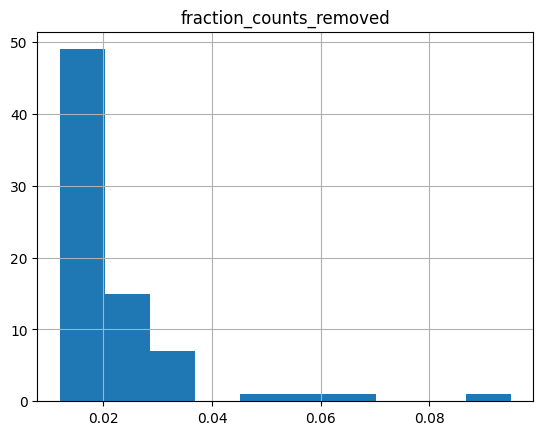

In [39]:
metrics.hist('fraction_counts_removed')

## QC

In [4]:
adatas = [x for x in os.listdir('clean_adata/') if x.endswith('filtered.h5')]
#you could also use a whitelist of barcodes from the filtered barcodes for each sample
#in this case, you would open the unfiltered then filter it based on the whitelist

In [6]:
#adatas

In [5]:
def load_it(adata):
    samp = adata.split('_')[1]
    dx = adata.split('_')[2]
    adata = sc.read_10x_h5('clean_adata/' + adata)
    adata.obs['Patient'] = samp
    adata.obs['DX'] = dx
    adata.obs['Sample'] = adata.obs['Patient'] + '_' + adata.obs['DX']
    adata.obs.index = adata.obs.index + '-' + samp + '_' + dx
    return adata

In [6]:
adatas = [load_it(ad) for ad in adatas]

In [7]:
#adatas

In [8]:
def qc(adata):
    
    #you could also use a whitelist of barcodes from the filtered barcodes for each sample
    sc.pp.filter_cells(adata, min_genes = 200) #if you use the whitelist, you can get rid of this
    
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

    remove = ['total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo', 
          'log1p_total_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb']
    
    adata.obs = adata.obs[[x for x in adata.obs.columns if x not in remove]]
    
    return adata

In [9]:
adatas = [qc(ad) for ad in adatas]

In [10]:
df = pd.concat([x.obs for x in adatas])

In [11]:
df = df.sort_values('Sample')

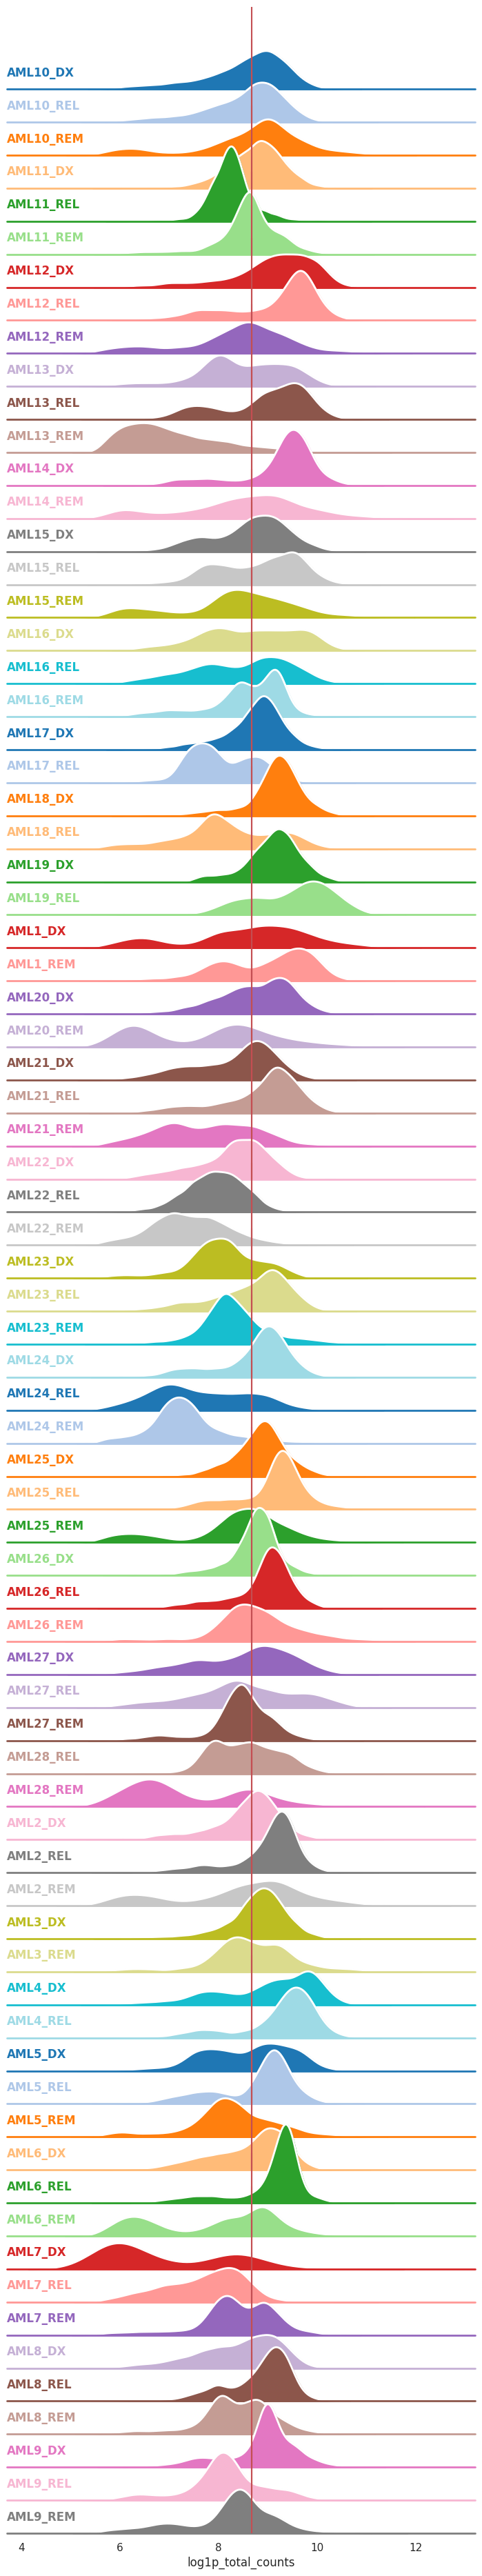

In [56]:
#value = "pct_counts_mt"
#value = "n_genes"
#value = 'pct_counts_in_top_20_genes'
value = "log1p_total_counts"

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(df, row="Sample", hue="Sample", aspect=15, height=0.5, palette="tab20")

g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)

g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, value)

g.figure.subplots_adjust(hspace=-.6)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

for ax in g.axes.flat:
    ax.axvline(x=df[value].median(), color='r', linestyle='-')


plt.show()

## Preprocessing (removing outliers and doublets)

Alternative doublet dection method: https://github.com/mousepixels/sanbomics_scripts/blob/main/doublet_removal_SOLO_scVI.ipynb

In [38]:
import doubletdetection
from scipy.stats import median_abs_deviation as mad
import numpy as np

In [59]:
a = df[df.Sample == 'AML10_REM'].log1p_total_counts

In [62]:
np.median(a)

8.897545514588673

In [61]:
np.median(a) - 5 * mad(a)

6.3832497277383995

In [63]:
np.median(a) + 5 * mad(a)

11.411841301438947

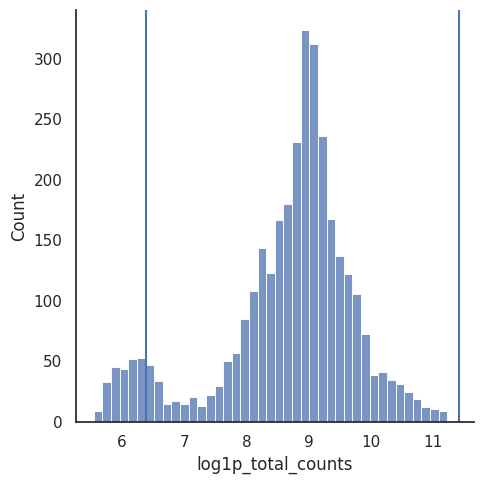

In [64]:
ax = sns.displot(a)

plt.axvline(np.median(a) - 5 * mad(a))
plt.axvline(np.median(a) + 5 * mad(a))

plt.show()

In [65]:
def mad_outlier(adata, metric, nmads, upper_only = False):
    M = adata.obs[metric]
    
    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    
    return (M > np.median(M) + nmads * mad(M))

In [86]:
clf = doubletdetection.BoostClassifier(
    n_iters=10,
    clustering_algorithm="louvain",
    standard_scaling=True,
    pseudocount=0.1,
    n_jobs=-1)

In [87]:
def pp(adata):
    adata = adata[adata.obs.pct_counts_mt < 25] #you can lower this based on the overal distribution of your dataset
    
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) +\
            mad_outlier(adata, 'pct_counts_mt', 3, upper_only = True)
    adata = adata[~bool_vector]

    adata.uns['cells_removed'] = sum(bool_vector)

    doublets = clf.fit(adata.X).predict(p_thresh=1e-3, voter_thresh=0.5)
    doublet_score = clf.doublet_score()

    adata.obs["doublet"] = doublets
    adata.obs["doublet_score"] = doublet_score

    adata.uns['doublets_removed'] = adata.obs.doublet.sum()
    adata = adata[adata.obs.doublet == 0]

    return adata
    

In [2]:
adatas = [pp(ad) for ad in adatas]

Note that these data were a little noisy and a higher proportion of cells were removed than what would be expected from a "clean" dataset

If the number of cells removed in MAD filtering is very large relative to overall cells, it may be worthwhile to increase thresholds or use a less conservative method. ~5-15% is typical.

Expected doublet rate is typically ~2-10% depending on the number of cells sequenced for 10x workflows

If anything deviates drastically, visit that sample specifically.

In [92]:
for adata in adatas:
    print(len(adata), adata.uns['cells_removed'], adata.uns['doublets_removed'])

1693 1186 91.0
2760 1837 283.0
3598 1116 369.0
3500 577 306.0
7886 3458 4297.0
2242 619 129.0
2874 1018 355.0
2888 1172 427.0
3630 1207 337.0
6768 984 721.0
6025 981 830.0
4178 437 564.0
5688 793 511.0
3332 999 441.0
4086 1122 475.0
1596 655 36.0
5016 781 993.0
5247 715 529.0
2314 892 84.0
3388 533 495.0
5065 684 423.0
3287 1310 481.0
1728 317 46.0
1643 504 48.0
1326 448 59.0
5376 856 604.0
6412 767 997.0
3553 1184 548.0
4207 984 308.0
5366 1051 486.0
5292 1216 1046.0
4182 434 524.0
5347 1461 490.0
7798 729 998.0
4079 922 321.0
6639 1011 1068.0
2352 418 166.0
4296 884 243.0
3088 684 458.0
5858 949 633.0
4889 525 369.0
4662 812 466.0
3845 566 379.0
3576 1688 336.0
4459 620 366.0
6080 1292 956.0
3307 798 341.0
5438 1495 1086.0
3486 807 508.0
5529 1432 554.0
1240 299 52.0
3983 769 466.0
4497 799 282.0
5776 1131 561.0
1501 212 65.0
5533 961 563.0
6345 1258 567.0
5766 860 590.0
2057 937 111.0
6567 1140 935.0
5931 1063 519.0
2803 861 204.0
2512 956 333.0
2531 590 128.0
4506 755 552.0
2269 10

In [ ]:
## if you wanted to look at distributions after pp (df is still saved as prior):

In [15]:
df2 = pd.concat([x.obs for x in adatas])
df2 = df2.sort_values('Sample')

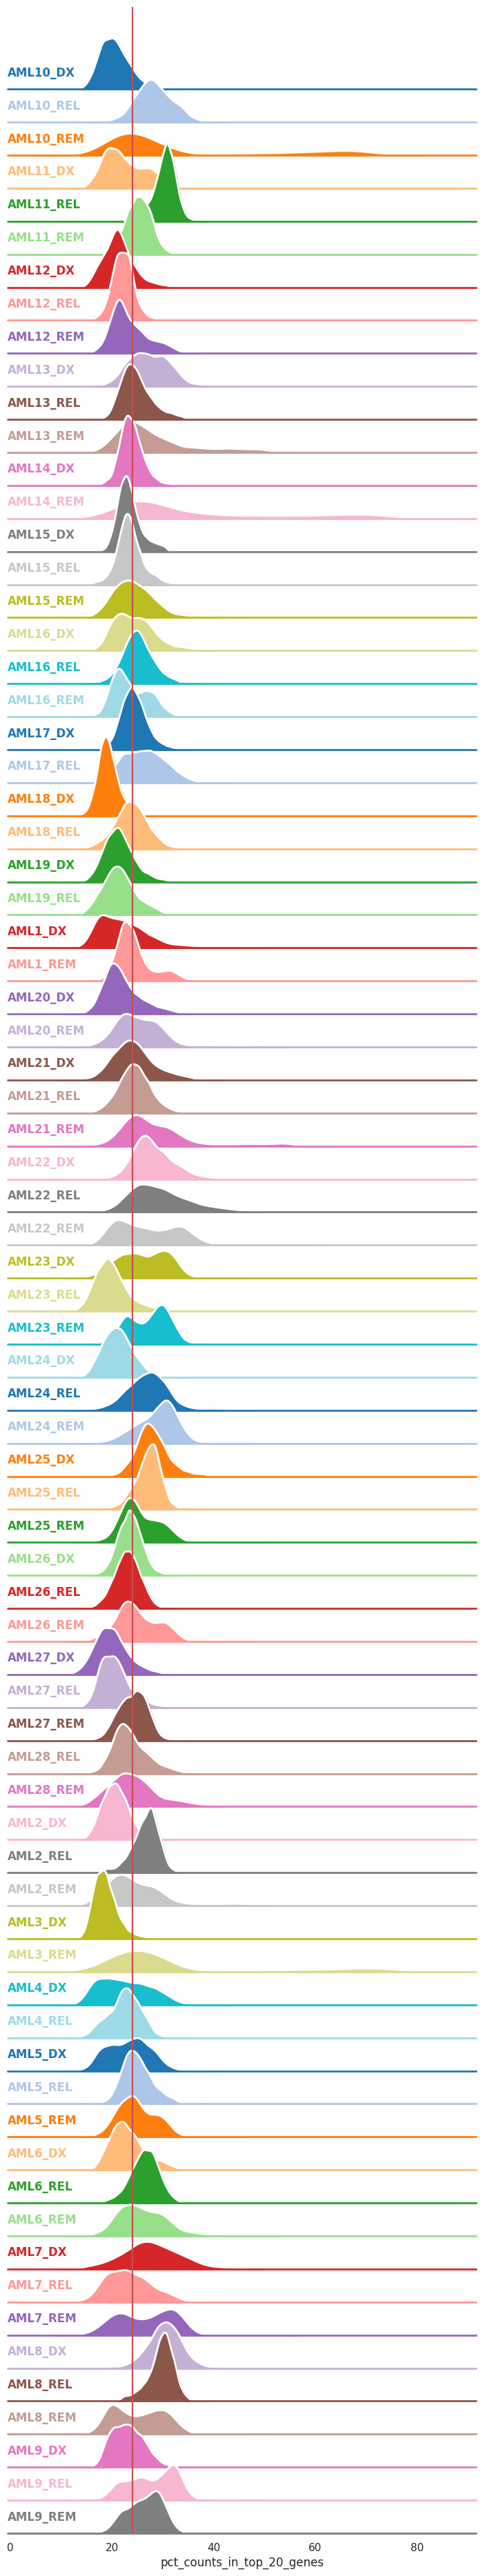

In [19]:
#value = "pct_counts_mt"
#value = "n_genes"
value = 'pct_counts_in_top_20_genes'
#value = "log1p_total_counts"

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(df2, row="Sample", hue="Sample", aspect=15, height=0.5, palette="tab20")

g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)

g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, value)

g.figure.subplots_adjust(hspace=-.6)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

for ax in g.axes.flat:
    ax.axvline(x=df2[value].median(), color='r', linestyle='-')


plt.show()